# MMA 823 Assignment 2

## load packages

In [2]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from yellowbrick.cluster import (
    SilhouetteVisualizer,
    InterclusterDistance,
    KElbowVisualizer,
)

import itertools

import scipy


# The following is just to change the display settings.
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_colwidth", 200)
pd.options.display.max_columns = None

%matplotlib inline

## Load data.

In [3]:
df=pd.read_excel('https://github.com/Wangmiaobeng/MMA_Share/releases/download/MMA823/Bankruptcy_data_Final.xlsx')

## Clean data

#### check the data

In [4]:
df.head()
df.info()

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1979,0.98,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,NaN,NaN,NaN,0
1,1980,0.98,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179,0
2,1981,0.87,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524,0
3,1982,1.13,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890,0
4,1983,1.26,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 15 columns):
Data Year - Fiscal    92872 non-null int64
Tobin's Q             92620 non-null float64
EPS                   92867 non-null float64
Liquidity             92625 non-null float64
Profitability         92625 non-null float64
Productivity          92625 non-null float64
Leverage Ratio        92846 non-null float64
Asset Turnover        92625 non-null float64
Operational Margin    87315 non-null float64
Return on Equity      92864 non-null float64
Market Book Ratio     92815 non-null float64
Assets Growth         86171 non-null float64
Sales Growth          86171 non-null float64
Employee Growth       85862 non-null float64
BK                    92872 non-null int64
dtypes: float64(13), int64(2)
memory usage: 10.6 MB


#### Set the year to string type

In [5]:
df['Data Year - Fiscal'] = df['Data Year - Fiscal'].apply(str)

#### check the correlation
* There is one group of features correlation coefficient large than 0.5.

* We will keep these features.

In [6]:
corr=df.corr()
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(np.bool))
corr_triu = corr_triu.stack()
corr_triu.name = 'Pearson Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']
corr_triu[(corr_triu > 0.5) | (corr_triu < -0.5) ].to_frame()

,,Pearson Correlation Coefficient
Col1,Col2,
Liquidity,Return on Equity,0.582335


#### Check the missing value

In [7]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [8]:
missing_value_df

,column_name,percent_missing
Data Year - Fiscal,Data Year - Fiscal,0.000000
Tobin's Q,Tobin's Q,0.271341
EPS,EPS,0.005384
Liquidity,Liquidity,0.265957
Profitability,Profitability,0.265957
Productivity,Productivity,0.265957
Leverage Ratio,Leverage Ratio,0.027996
Asset Turnover,Asset Turnover,0.265957
Operational Margin,Operational Margin,5.983504
Return on Equity,Return on Equity,0.008614


##### Check the ratio of target

* This is an imbanlanced data set

In [9]:
BK0_ratio=len(df[df.BK==0])/len(df)
BK1_ratio=len(df[df.BK==1])/len(df)
print(BK0_ratio)
print(BK1_ratio)


0.9939917305538806
0.00600826944611939


##### Check the ratio of target which has missing value 

In [10]:
null_data = df[df.isnull().any(axis=1)]

In [11]:
print(len(null_data[null_data.BK==0])/len(null_data))
print(len(null_data[null_data.BK==1])/len(null_data))

0.9927151182721975
0.007284881727802537


##### Check the target ratio relative ratio of each missing feature

In [12]:
BK_ratio_dict={}
BK_ratio_dict['variable']=[]
BK_ratio_dict['total_missing']=[]
BK_ratio_dict['BK1_ratio']=[]
BK_ratio_dict['BK1_ratio_relative']=[]

for i in list(df.columns)[1:-1]:
  temp_df=df[df[i].isnull()]
  BK_ratio_dict['variable'].append(i)
  temp_ratio=len(temp_df[temp_df.BK==1])/len(temp_df)
  BK_ratio_dict['BK1_ratio'].append(temp_ratio)
  BK_ratio_dict['BK1_ratio_relative'].append( abs((temp_ratio-BK1_ratio)/BK1_ratio))
  BK_ratio_dict['total_missing'].append(len(temp_df))

In [13]:
pd.DataFrame(BK_ratio_dict).sort_values('BK1_ratio_relative',ascending=False)

,variable,total_missing,BK1_ratio,BK1_ratio_relative
1,EPS,5,0.800000,132.149821
8,Return on Equity,8,0.500000,82.218638
9,Market Book Ratio,57,0.157895,25.279570
5,Leverage Ratio,26,0.038462,5.401434
2,Liquidity,247,0.000000,1.000000
3,Profitability,247,0.000000,1.000000
4,Productivity,247,0.000000,1.000000
6,Asset Turnover,247,0.000000,1.000000
10,Assets Growth,6701,0.000000,1.000000
11,Sales Growth,6701,0.000000,1.000000


* After checking all the missing values, I decided to impute the missing value with 0.

##### define a function to create dummy feature to catch the missing value before imputing

In [14]:
def create_surrogate(df_data):
  data_frame=df_data.copy()
  for i in list(data_frame.columns):
    if sum(data_frame[i].isnull())>=1:
      data_frame[i+'_surrogate']=np.where(pd.isnull(data_frame[i]),1,0)
  return data_frame

##### apple the function to create the dummy feature

In [15]:
df_with_surrogate=create_surrogate(df)

##### impute with 0

In [16]:
df_cleaned=df_with_surrogate.fillna(0)

In [17]:
df_cleaned.head()
df_cleaned.info()

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK,Tobin's Q_surrogate,EPS_surrogate,Liquidity_surrogate,Profitability_surrogate,Productivity_surrogate,Leverage Ratio_surrogate,Asset Turnover_surrogate,Operational Margin_surrogate,Return on Equity_surrogate,Market Book Ratio_surrogate,Assets Growth_surrogate,Sales Growth_surrogate,Employee Growth_surrogate
0,1979,0.98,1.58,0.36,0.18,0.13,1.33,1.77,0.07,0.15,2.22,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,1980,0.98,1.41,0.36,0.19,0.12,1.31,1.59,0.07,0.13,2.41,0.126319,0.014278,0.040179,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1981,0.87,0.31,0.32,0.13,0.08,1.03,1.55,0.05,0.04,2.56,0.368077,0.327909,0.566524,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1982,1.13,0.71,0.28,0.14,0.08,0.80,1.39,0.06,0.05,5.28,-0.020809,-0.118904,-0.095890,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1983,1.26,0.75,0.41,0.13,0.08,0.20,1.30,0.06,0.04,8.68,0.233089,0.146807,0.053030,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 28 columns):
Data Year - Fiscal              92872 non-null object
Tobin's Q                       92872 non-null float64
EPS                             92872 non-null float64
Liquidity                       92872 non-null float64
Profitability                   92872 non-null float64
Productivity                    92872 non-null float64
Leverage Ratio                  92872 non-null float64
Asset Turnover                  92872 non-null float64
Operational Margin              92872 non-null float64
Return on Equity                92872 non-null float64
Market Book Ratio               92872 non-null float64
Assets Growth                   92872 non-null float64
Sales Growth                    92872 non-null float64
Employee Growth                 92872 non-null float64
BK                              92872 non-null int64
Tobin's Q_surrogate             92872 non-null int64
EPS_surrogate   

In [18]:
x=list( df_cleaned.columns)
x.remove('BK')
x

['Data Year - Fiscal',
 "Tobin's Q",
 'EPS',
 'Liquidity',
 'Profitability',
 'Productivity',
 'Leverage Ratio',
 'Asset Turnover',
 'Operational Margin',
 'Return on Equity',
 'Market Book Ratio',
 'Assets Growth',
 'Sales Growth',
 'Employee Growth',
 "Tobin's Q_surrogate",
 'EPS_surrogate',
 'Liquidity_surrogate',
 'Profitability_surrogate',
 'Productivity_surrogate',
 'Leverage Ratio_surrogate',
 'Asset Turnover_surrogate',
 'Operational Margin_surrogate',
 'Return on Equity_surrogate',
 'Market Book Ratio_surrogate',
 'Assets Growth_surrogate',
 'Sales Growth_surrogate',
 'Employee Growth_surrogate']

## Scale data

In [19]:
features =list( df_cleaned.columns)
features.remove('BK')
features_to_be_scaled=features[1:15]

X=df_cleaned[features]
y=df_cleaned['BK']
X[features_to_be_scaled] = StandardScaler().fit_transform(X[features_to_be_scaled])
X.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,Tobin's Q_surrogate,EPS_surrogate,Liquidity_surrogate,Profitability_surrogate,Productivity_surrogate,Leverage Ratio_surrogate,Asset Turnover_surrogate,Operational Margin_surrogate,Return on Equity_surrogate,Market Book Ratio_surrogate,Assets Growth_surrogate,Sales Growth_surrogate,Employee Growth_surrogate
0,1979,-0.026975,0.007306,0.024572,0.043823,0.037659,-0.000059,0.340233,0.036123,0.006416,-0.013666,-0.016897,-0.010304,-0.023455,-0.052161,0,0,0,0,0,0,0,0,0,1,1,1
1,1980,-0.026975,0.007229,0.024572,0.043838,0.037380,-0.000138,0.255079,0.036123,0.006359,-0.013658,-0.015120,-0.010220,-0.020486,-0.052161,0,0,0,0,0,0,0,0,0,0,0,0
2,1981,-0.027097,0.006728,0.024243,0.043749,0.036264,-0.001245,0.236155,0.036027,0.006104,-0.013653,-0.011717,-0.008387,0.018408,-0.052161,0,0,0,0,0,0,0,0,0,0,0,0
3,1982,-0.026808,0.006910,0.023913,0.043764,0.036264,-0.002154,0.160463,0.036075,0.006133,-0.013548,-0.017190,-0.010999,-0.030540,-0.052161,0,0,0,0,0,0,0,0,0,0,0,0
4,1983,-0.026664,0.006928,0.024984,0.043749,0.036264,-0.004525,0.117886,0.036075,0.006104,-0.013418,-0.013617,-0.009446,-0.019536,-0.052161,0,0,0,0,0,0,0,0,0,0,0,0


## Seperate data into train and test

In [20]:
sum(y)/len(y) # check the ratio of True in target

0.00600826944611939

In [21]:
sum(y)

558

In [22]:
X.iloc[:,0:1].nunique()

Data Year - Fiscal    39
dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
X_train_UN, X_test, y_train_UN, y_test = train_test_split(X, y, test_size=0.2, random_state=1028, stratify=y)

## Balance data

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
 sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train_UN, y_train_UN)
sum(y_train)/len(y_train)

0.5

## Build models

#### Decision Tree

In [27]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss,roc_auc_score,precision_score,recall_score
def score_list(predicion,y_test=y_test):
  '''this function will print Accurarcy, Kappa, F1 score, Log Loss and AUC'''
  print('\n ****************************')
  print("Accuracy = {:.2f}".format(accuracy_score(y_test, predicion)))
  print("F1 Score = {:.2f}".format(f1_score(y_test, predicion)))
  print("AUC = {:.2f}".format(roc_auc_score(y_test, predicion)))
  print("Precision = {:.2f}".format(precision_score(y_test, predicion)))
  print("Recall = {:.2f}".format(recall_score(y_test, predicion)))
  print('**************************** \n')

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# build model using grid search with 5Fold Cross validation to train and test
treeclf = DecisionTreeClassifier(splitter='best', presort=True, class_weight=None, random_state=42)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2, 4, 6, 8, 10], 'min_samples_split':[2, 10, 50], 'min_samples_leaf':[1, 5, 10],
             'max_features':[None, 'auto'], 'max_leaf_nodes':[None, 5, 10, 50], 'min_impurity_decrease':[0, 0.1, 0.2]}
cv_clf = GridSearchCV(treeclf, parameters, scoring='roc_auc', cv=5, return_train_score=True)
cv_clf.fit(X_train, y_train)

# predict on test data
y_pred_dt_cv = cv_clf.predict(X_test)

# print the score with the function defined myself
score_list(y_pred_dt_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6, 8, 10],
                        


 ****************************
Accuracy = 0.93
F1 Score = 0.11
AUC = 0.84
Precision = 0.06
Recall = 0.75
**************************** 



In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    score = clf.score(X_test, y_test);

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=cm_bright, edgecolors='k');
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=35, horizontalalignment='right');
    ax.grid();
    
    


def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

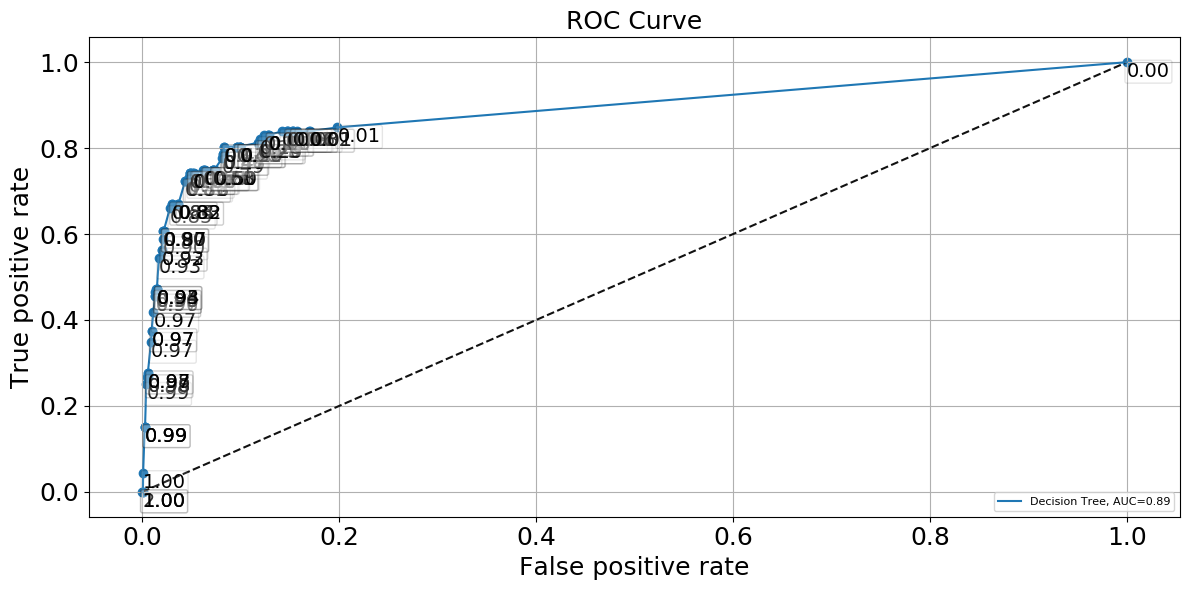

In [55]:
plt.style.use('default');
figure = plt.figure(figsize=(12, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(cv_clf, X_test, y_test, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=8);
plt.tight_layout();

#### GaussianNB

In [29]:
from sklearn.naive_bayes import GaussianNB

# build model using grid search with 5Fold Cross validation to train and test
gnb = GaussianNB()
parameters = {"var_smoothing":[1e-7,1e-8,1e-9,1e-10,1e-11]}
cv_gnb = GridSearchCV(gnb, parameters, scoring='roc_auc', cv=5, return_train_score=True)
cv_gnb.fit(X_train, y_train)

# predict on test data
y_pred_gnb_cv = cv_gnb.predict(X_test)

# print the score with the function defined myself
score_list(y_pred_gnb_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=None,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-10, 1e-11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)


 ****************************
Accuracy = 0.15
F1 Score = 0.01
AUC = 0.53
Precision = 0.01
Recall = 0.91
**************************** 



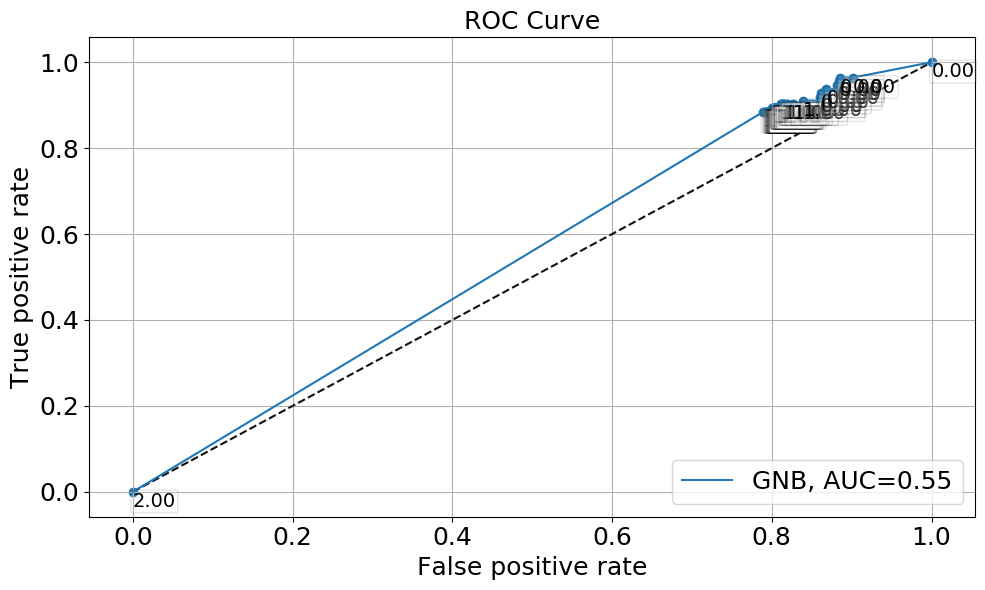

In [59]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(cv_gnb, X_test, y_test, "GNB", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

#### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier


# build model using grid search with 5Fold Cross validation to train and test
knn_clf = KNeighborsClassifier()
parameters = {"n_neighbors":range(2,11)}
cv_knn_clf = GridSearchCV(knn_clf, parameters, scoring='roc_auc', cv=5, return_train_score=True)
cv_knn_clf.fit(X_train, y_train)

# predict on test data
y_pred_knn_clf_cv = cv_knn_clf.predict(X_test)

# print the score with the function defined myself
score_list(y_pred_knn_clf_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None, param_grid={'n_neighbors': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)


 ****************************
Accuracy = 0.94
F1 Score = 0.08
AUC = 0.69
Precision = 0.04
Recall = 0.44
**************************** 



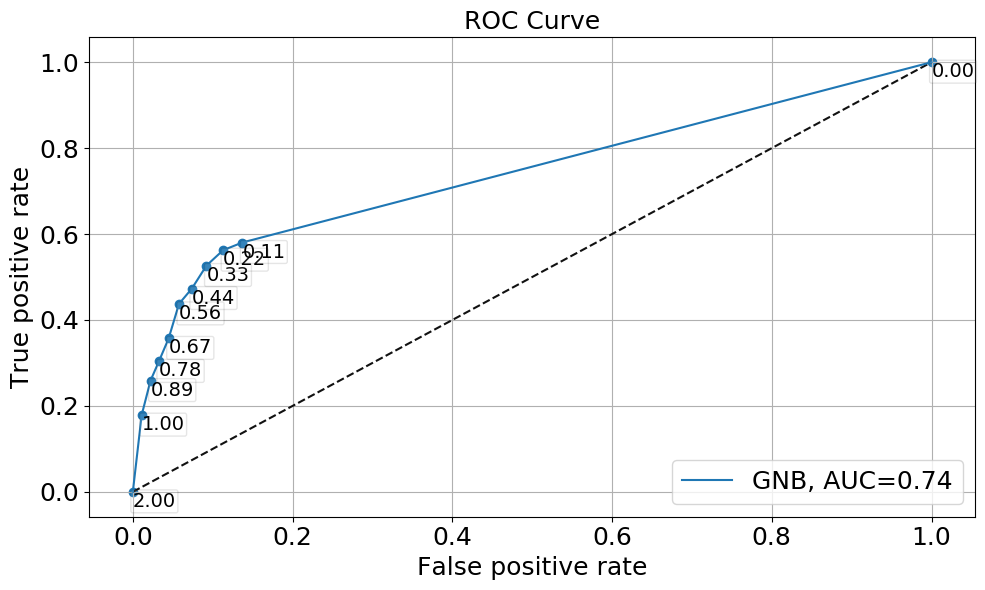

In [61]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(cv_knn_clf, X_test, y_test, "GNB", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

#### Nerual Network

In [31]:
from sklearn.neural_network import MLPClassifier


# build model using grid search with 5Fold Cross validation to train and test
nn_clf = MLPClassifier(solver='lbfgs',random_state=1, verbose=False)
parameters = {'activation':['logistic','tanh','relu'],'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3],'hidden_layer_sizes':range(2,11)}
cv_nn_clf = GridSearchCV(nn_clf, parameters, scoring='roc_auc', cv=5, return_train_score=False)
cv_nn_clf.fit(X_train, y_train)

# predict on test data
y_pred_nn_clf_cv = cv_nn_clf.predict(X_test)

# print the score with the function defined myself
score_list(y_pred_nn_clf_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1, shuffle=True,
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],


 ****************************
Accuracy = 0.99
F1 Score = 0.00
AUC = 0.50
Precision = 0.00
Recall = 0.00
**************************** 



#### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier


# build model using grid search with 5Fold Cross validation to train and test
rf_clf = RandomForestClassifier(random_state=1120)
parameters = {"n_estimators":[50,100,200,300],'max_depth':[2,5,8,11]}
cv_rf_clf = GridSearchCV(rf_clf, parameters, scoring='roc_auc', cv=5, return_train_score=False)
cv_rf_clf.fit(X_train, y_train)

# predict on test data
y_pred_rf_clf_cv = cv_rf_clf.predict(X_test)

# print the score with the function defined myself
score_list(y_pred_rf_clf_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=1120, verbose=0,
                                              warm_start=False),
             iid


 ****************************
Accuracy = 0.95
F1 Score = 0.15
AUC = 0.83
Precision = 0.08
Recall = 0.71
**************************** 



## Model result

In [33]:
dict_score={}
for i in [accuracy_score, f1_score,roc_auc_score,precision_score,recall_score]:
  dict_score[i.__name__]=[]
  for k in [y_pred_dt_cv,y_pred_gnb_cv,y_pred_knn_clf_cv,y_pred_nn_clf_cv,y_pred_rf_clf_cv]:
    dict_score[i.__name__].append(round(i(y_test,k),3))

df8_6=pd.DataFrame(dict_score,index=['Decision Trees','Naive Bayes','k-nearest neighbors','neural network','random forest'])
df8_6.sort_values('roc_auc_score',ascending=False)

,accuracy_score,f1_score,roc_auc_score,precision_score,recall_score
Decision Trees,0.927,0.110,0.839,0.059,0.750
random forest,0.950,0.147,0.833,0.082,0.714
k-nearest neighbors,0.939,0.080,0.690,0.044,0.438
Naive Bayes,0.149,0.013,0.528,0.006,0.911
neural network,0.994,0.000,0.500,0.000,0.000
